In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/helloworld/text_data.csv


In [3]:
import os
import gc
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import GPT2Tokenizer, TFAutoModel
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from joblib import dump
import json
import shutil

# Enable mixed precision
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

# Load and preprocess data
file_path = '/kaggle/input/helloworld/text_data.csv'
df = pd.read_csv(file_path)
df = df.dropna(subset=['text'])
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

features = ['avg line length', 'word density', 'mean_perplexity', 'burstiness2', 'flesch_kincaid_score', 'gunning_fog_score']
for feature in features:
    df[feature].fillna(df[feature].mean(), inplace=True)

texts = df['text'].tolist()
additional_features = df[features].values
labels = df['label'].tolist()
del df
gc.collect()

scaler = StandardScaler()
additional_features = scaler.fit_transform(additional_features)

# Load tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.add_special_tokens({'pad_token': tokenizer.eos_token})
gpt2_model = TFAutoModel.from_pretrained("gpt2")

MAX_SEQ_LENGTH = 512

def batch_tokenize(texts, tokenizer, batch_size=32, max_length=MAX_SEQ_LENGTH):
    input_ids_list = []
    attention_mask_list = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, padding='max_length', truncation=True, max_length=max_length, return_tensors='tf')
        input_ids_list.append(inputs['input_ids'])
        attention_mask_list.append(inputs['attention_mask'])
    input_ids = tf.concat(input_ids_list, axis=0)
    attention_masks = tf.concat(attention_mask_list, axis=0)
    return input_ids, attention_masks

input_ids, attention_masks = batch_tokenize(texts, tokenizer)
input_ids = input_ids.numpy()
attention_masks = attention_masks.numpy()
labels = np.array(labels)

del texts
gc.collect()

# Model architecture
class GPT2WithAdditionalFeatures(tf.keras.Model):
    def __init__(self, gpt2_model, num_additional_features, num_classes, dropout_rate):
        super().__init__()
        self.gpt2 = gpt2_model
        self.num_additional_features = num_additional_features
        self.num_classes = num_classes
        self.dropout_rate = dropout_rate
        self.additional_features_layer = tf.keras.layers.Dense(768, activation='relu', kernel_regularizer=l2(1e-5))
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
        self.concat_layer = tf.keras.layers.Concatenate()
        self.dense1 = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=l2(1e-5))
        self.dense2 = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(1e-5))
        self.classifier = tf.keras.layers.Dense(num_classes, activation='sigmoid', kernel_regularizer=l2(1e-5))

    def call(self, inputs):
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        additional_features = inputs['additional_features']

        gpt2_output = self.gpt2(input_ids, attention_mask=attention_mask)[0]
        pooled_output = tf.reduce_mean(gpt2_output, axis=1)
        pooled_output = self.dropout1(pooled_output)
        
        additional_features = self.additional_features_layer(additional_features)
        additional_features = self.dropout2(additional_features)
        
        concatenated = self.concat_layer([pooled_output, additional_features])
        x = self.dense1(concatenated)
        x = self.dense2(x)
        output = self.classifier(x)
        return output

# Split the data into training and testing sets
train_inputs, test_inputs, train_masks, test_masks, train_features, test_features, train_labels, test_labels = train_test_split(
    input_ids, attention_masks, additional_features, labels, test_size=0.2, random_state=42
)
BATCH_SIZE = 16

# Create datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    {"input_ids": train_inputs, "attention_mask": train_masks, "additional_features": train_features},
    train_labels
)).shuffle(1000).batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((
    {"input_ids": test_inputs, "attention_mask": test_masks, "additional_features": test_features},
    test_labels
)).batch(BATCH_SIZE)

# Training setup
EPOCHS = 1
LEARNING_RATE = 1e-4
DROPOUT_RATE = 0.2

# Learning rate schedule
def cosine_decay_with_warmup(epoch, total_epochs, warmup_epochs, learning_rate):
    if epoch < warmup_epochs:
        return learning_rate * (epoch + 1) / warmup_epochs
    progress = (epoch - warmup_epochs) / (total_epochs - warmup_epochs)
    return learning_rate * 0.5 * (1 + np.cos(np.pi * progress))

lr_schedule = lambda epoch: cosine_decay_with_warmup(epoch, EPOCHS, 2, LEARNING_RATE)

model = GPT2WithAdditionalFeatures(gpt2_model, num_additional_features=6, num_classes=1, dropout_rate=DROPOUT_RATE)

optimizer = Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc'),
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    LearningRateScheduler(lr_schedule),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)
]

history = model.fit(train_dataset, 
                    epochs=EPOCHS, 
                    validation_data=test_dataset, 
                    callbacks=callbacks)

# Evaluate the model on the test set
print("Evaluating on test set:")
test_results = model.evaluate(test_dataset)
print("Test results:")
print(f"Loss: {test_results[0]:.4f}")
print(f"Accuracy: {test_results[1]:.4f}")
print(f"AUC: {test_results[2]:.4f}")
print(f"Precision: {test_results[3]:.4f}")
print(f"Recall: {test_results[4]:.4f}")

# Get predictions on the test set
test_predictions = model.predict(test_dataset)
predicted_labels = (test_predictions > 0.5).astype(int).flatten()

# Confusion Matrix
cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report
report = classification_report(test_labels, predicted_labels, output_dict=True)
df_report = pd.DataFrame(report).transpose()
plt.figure(figsize=(10, 8))
sns.heatmap(df_report.iloc[:-1, :].drop('support', axis=1).astype(float), annot=True, cmap='YlGnBu')
plt.title('Classification Report')
plt.show()

# Training History
plt.figure(figsize=(12, 4))

# Loss graph
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.scatter(len(history.history['loss'])-1, test_results[0], color='red', label='Test Loss')
plt.title('Training, Validation, and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy graph
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.scatter(len(history.history['accuracy'])-1, test_results[1], color='red', label='Test Accuracy')
plt.title('Training, Validation, and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Save the final model
@tf.function(input_signature=[
    {
        "input_ids": tf.TensorSpec(shape=[None, MAX_SEQ_LENGTH], dtype=tf.int32),
        "attention_mask": tf.TensorSpec(shape=[None, MAX_SEQ_LENGTH], dtype=tf.int32),
        "additional_features": tf.TensorSpec(shape=[None, 6], dtype=tf.float32)
    }
])
def serving_fn(inputs):
    return model(inputs)

output_directory = '6features_saved'
tf.saved_model.save(model, output_directory, signatures={'serving_default': serving_fn})

# Save the scaler
dump(scaler, f'{output_directory}/scaler.joblib')

# Save the tokenizer
tokenizer.save_pretrained(f'{output_directory}/tokenizer')

# Save the configuration
config = {
    'max_seq_length': MAX_SEQ_LENGTH,
    'features': features,
    'num_additional_features': len(features)
}

with open(f'{output_directory}/config.json', 'w') as f:
    json.dump(config, f)

# Zip the directory
zip_file_name = "output_files_save.zip"
shutil.make_archive(zip_file_name.replace('.zip', ''), 'zip', output_directory)

# Move the zip file to the output directory for download
shutil.move(zip_file_name, f"/kaggle/working/{zip_file_name}")

print(f"{zip_file_name} created and moved to /kaggle/working/")

output_files_save.zip created and moved to /kaggle/working/


Contents of the model directory: ['variables', 'saved_model.pb', 'scaler.joblib', 'tokenizer', 'fingerprint.pb', 'config.json', 'assets']
Model loaded successfully
((), {'inputs_2': TensorSpec(shape=(None, 512), dtype=tf.int32, name='inputs_2'), 'inputs_1': TensorSpec(shape=(None, 512), dtype=tf.int32, name='inputs_1'), 'inputs': TensorSpec(shape=(None, 6), dtype=tf.float32, name='inputs')})
Scaler loaded successfully
Tokenizer loaded successfully
Configuration loaded successfully
Loaded configuration: {'max_seq_length': 512, 'features': ['avg line length', 'word density', 'mean_perplexity', 'burstiness2', 'flesch_kincaid_score', 'gunning_fog_score'], 'num_additional_features': 6}
                                                text  prediction  label
0  short version huge country tons people natural...           1      0
1  super massive blackhole bright sphere actually...           1      0
2  problem customers hate bloatware ones hate nt ...           1      0
3  although geographic

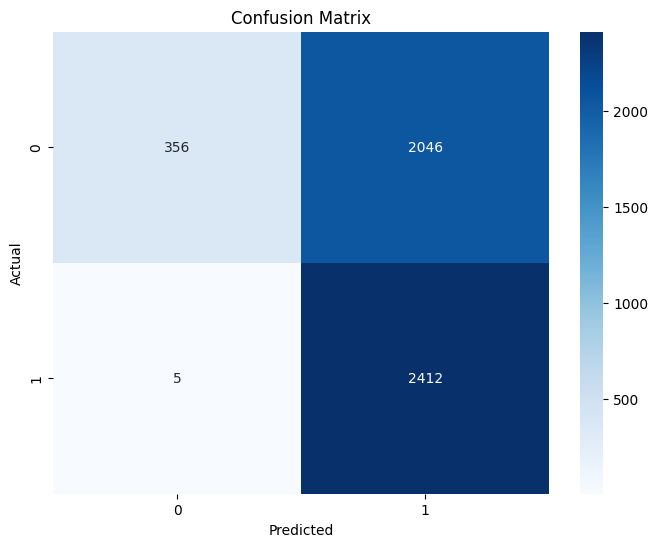

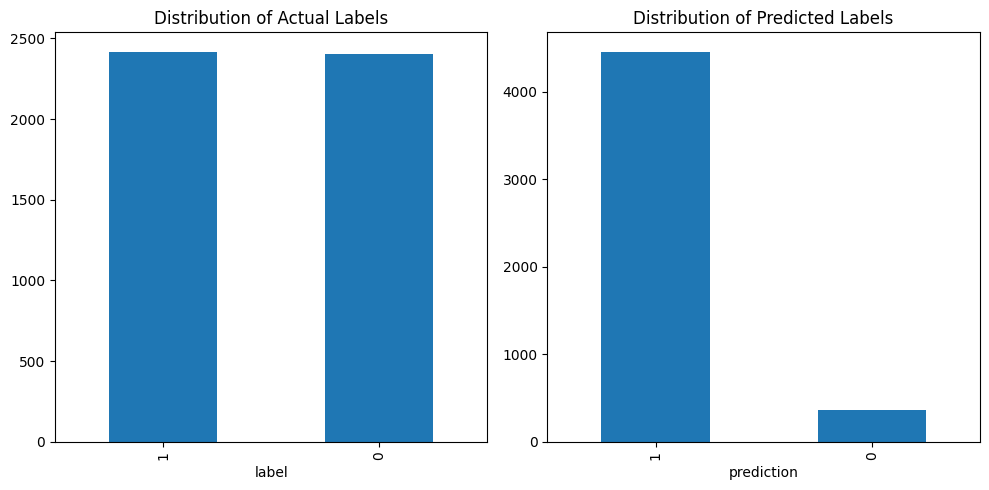

In [8]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
from transformers import GPT2Tokenizer
from joblib import load
import json
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Specify the path to the directory containing the saved model components
model_path = '/kaggle/working/model_directory'  # Adjust this path if necessary

print("Contents of the model directory:", os.listdir(model_path))

# Load the SavedModel
try:
    loaded_model = tf.saved_model.load(model_path)
    print("Model loaded successfully")
except OSError as e:
    print(f"Error loading SavedModel: {e}")
    raise
print(loaded_model.signatures["serving_default"].structured_input_signature)
# Load the scaler
try:
    scaler = load(os.path.join(model_path, 'scaler.joblib'))
    print("Scaler loaded successfully")
except Exception as e:
    print(f"Error loading scaler: {e}")
    raise

# Load the tokenizer
try:
    tokenizer = GPT2Tokenizer.from_pretrained(os.path.join(model_path, 'tokenizer'))
    print("Tokenizer loaded successfully")
except Exception as e:
    print(f"Error loading tokenizer: {e}")
    raise

# Load the configuration
try:
    with open(os.path.join(model_path, 'config.json'), 'r') as f:
        config = json.load(f)
    print("Configuration loaded successfully")
except Exception as e:
    print(f"Error loading configuration: {e}")
    raise

print("Loaded configuration:", config)

# Function to preprocess the data
def preprocess_data(texts, additional_features, max_length=config['max_seq_length']):
    # Tokenize the texts
    inputs = tokenizer(texts, padding='max_length', truncation=True, max_length=max_length, return_tensors='tf')
    input_ids = inputs['input_ids']
    attention_masks = inputs['attention_mask']
    
    # Scale the additional features
    scaled_features = scaler.transform(additional_features)
    
    return input_ids, attention_masks, scaled_features

# Load your new data for prediction
# Replace 'new_data.csv' with your actual data file
new_data = pd.read_csv('/kaggle/input/testdata/df_10.csv')

# Prepare the inputs
texts = new_data['text'].tolist()
features = ['avg line length', 'word density', 'mean_perplexity', 'burstiness2', 'flesch_kincaid_score', 'gunning_fog_score']

additional_features = new_data[config['features']].values

# Check if 'label' column exists in the new data
has_labels = 'label' in new_data.columns

# Preprocess the data
input_ids, attention_masks, scaled_features = preprocess_data(texts, additional_features)

# Modify the dataset creation
dataset = tf.data.Dataset.from_tensor_slices({
    "inputs_1": input_ids,
    "inputs_2": attention_masks,
    "inputs": tf.cast(scaled_features, tf.float32)  # Cast to float32
}).batch(32)

# Get the correct signature for prediction
infer = loaded_model.signatures["serving_default"]

# Make predictions
predictions = []
for batch in dataset:
    batch_predictions = infer(
        inputs=batch['inputs'],
        inputs_1=batch['inputs_1'],
        inputs_2=batch['inputs_2']
    )
    predictions.extend(batch_predictions['output_0'].numpy().flatten())

# Convert predictions to binary (0 or 1)
binary_predictions = (np.array(predictions) > 0.5).astype(int)

# Add predictions to the dataframe
new_data['prediction'] = binary_predictions

# Print some sample predictions
print(new_data[['text', 'prediction'] + (['label'] if has_labels else [])].head())

# If you want to save the predictions
new_data.to_csv('predictions.csv', index=False)
print("Predictions saved to 'predictions.csv'")

# Compare predictions with actual labels if available
if has_labels:
    true_labels = new_data['label'].values
    
    # Calculate metrics
    accuracy = accuracy_score(true_labels, binary_predictions)
    precision = precision_score(true_labels, binary_predictions)
    recall = recall_score(true_labels, binary_predictions)
    f1 = f1_score(true_labels, binary_predictions)
    
    print(f"\nEvaluation Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(true_labels, binary_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Distribution of predictions vs actual labels
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    new_data['label'].value_counts().plot(kind='bar')
    plt.title('Distribution of Actual Labels')
    plt.subplot(1, 2, 2)
    new_data['prediction'].value_counts().plot(kind='bar')
    plt.title('Distribution of Predicted Labels')
    plt.tight_layout()
    plt.show()
else:
    print("\nNo 'label' column found in the new data. Unable to compare predictions with actual labels.")